In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import matplotlib.cm as cm

In [13]:
# importing feature extractions methods from sklearn 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words 

In [14]:
# pre-processing of text 
import string 
import re 

In [15]:
# import classifiers from sklearn 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [16]:
# import different metrics to evaluate the classifiers 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# import time function from time module to track the training duration 
from time import time 

In [17]:
!wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
!ls -lah DATAPATH

--2021-02-02 04:42:44--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv.1’

Full-Economic-News- 100%[===================>]  11.81M  35.2MB/s    in 0.3s    

2021-02-02 04:42:44 (35.2 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv.1’ saved [12383529/12383529]

total 24M
drwxr-xr-x 2 root root 4.0K Feb  2 04:42 .
drwxr-xr-x 1 root root 4.0K Feb  2 04:34 ..
-rw-r--r-- 1 root root  12M Feb  2 04:34 Full-Economic-News-DFE-839861.csv
-rw-r--r-- 1 root root  12M Feb  2 04:42 Full-Economic-News-DFE-839861.csv.1


In [18]:
our_data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv", encoding="ISO-8859-1")
display(our_data.shape)

(8000, 15)

In [19]:
our_data["relevance"].value_counts()/our_data.shape[0] # class distribution in the dataset

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [20]:
# convert label to a numerical variable 
our_data = our_data[our_data.relevance != "not sure"]
print(our_data.shape)
our_data["relevance"] = our_data.relevance.map({'yes':1, 'no':0})
our_data = our_data[['text', 'relevance']]
print(our_data.shape)

(7991, 15)
(7991, 2)


Section 3 : Text-Pre-processing

In [21]:
stopwords = stop_words.ENGLISH_STOP_WORDS

def clean(doc):
    doc = doc.replace("</br>", " ")
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    return doc 

In [22]:
import sklearn 
from sklearn.model_selection import train_test_split

#step 1 : train-test-split 
X = our_data.text #the column text contains textual data to extract features from 
y = our_data.relevance #this is the column we are learning to predict 
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [23]:
# step 2 & 3 Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) # instance is created 
X_train_dtm = vect.fit_transform(X_train)
#transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

(5993, 49753) (1998, 49753)


In [26]:
# step 3 Train the classifiers and predict for test data 
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

CPU times: user 13.6 ms, sys: 0 ns, total: 13.6 ms
Wall time: 18.2 ms


Accuracy:  0.7822822822822822
ROC_AOC_Score:  0.7251117679464362


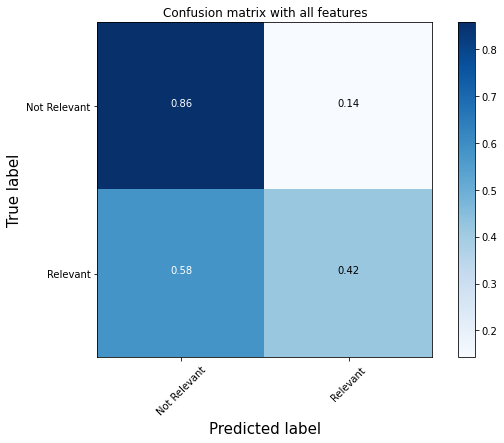

In [27]:
#Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    
#Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
#Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

CPU times: user 10.4 ms, sys: 27 µs, total: 10.5 ms
Wall time: 10.5 ms
Accuracy:  0.7822822822822822


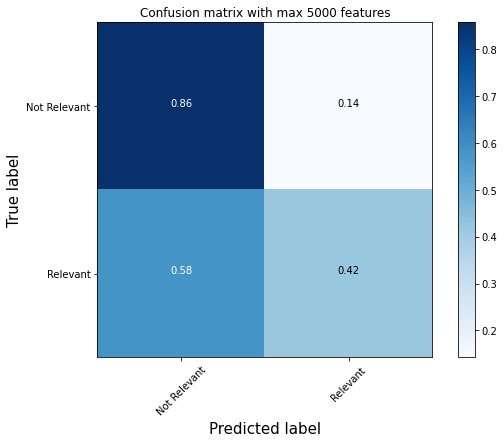

In [28]:
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with max 5000 features')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.7682682682682682
AUC:  0.7251117679464362


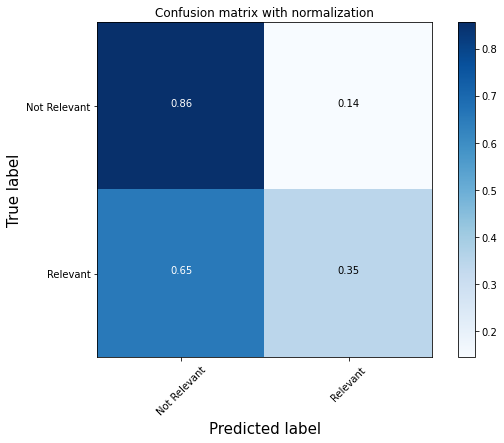

In [29]:
from sklearn.linear_model import LogisticRegression #import

logreg = LogisticRegression(class_weight="balanced") #instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy:  0.6896896896896897
AUC:  0.7251117679464362


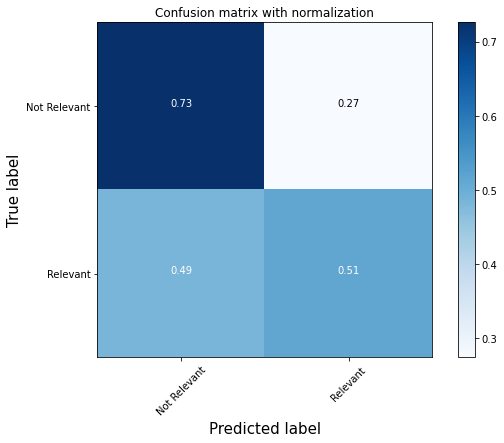

In [30]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') #instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')